In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pink_utils as pu
import scipy as sp
from scipy.ndimage import rotate as img_rotate 
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
transform = pu.transform('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Transform_Matrix.bin')
ed        = pu.heatmap('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_ED_Matrix.bin')
som       = pu.som('../Experiment/Experiment_F3W2_95_5/Results/F3W2_95_5/F3W2S_95_5_6.bin')
images    = pu.image_binary('../Experiment/Experiment_F3W2_95_5/Results/F3W2_95_5.bin')
df        = pd.read_csv('../Experiment/Experiment_F3W2_95_5/FIRST_Cata_Images.csv')

df.shape

/Users/gal16b/miniconda3/envs/pink_e3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(103929, 76)

In [3]:
print(SkyCoord(ra=df['radio.ra'][0]*u.degree, dec=df['radio.dec'][0]*u.degree, frame='icrs').ra)

206d24m37.3028s


/Users/gal16b/miniconda3/envs/pink_e3/lib/python3.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


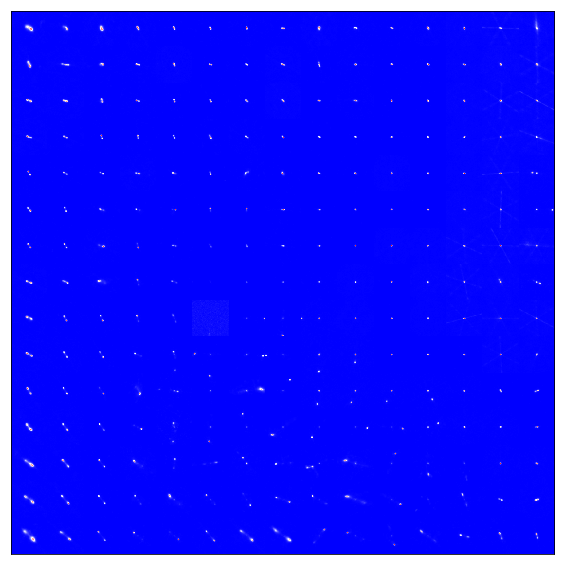

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.imshow(som.get_som(channel=0), cmap='bwr')

pu.no_ticks(ax)

fig.show()

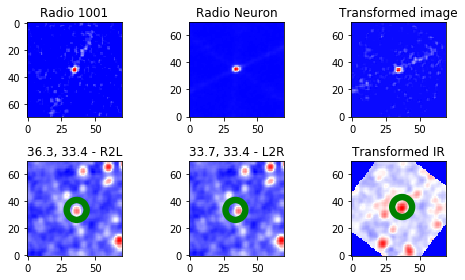

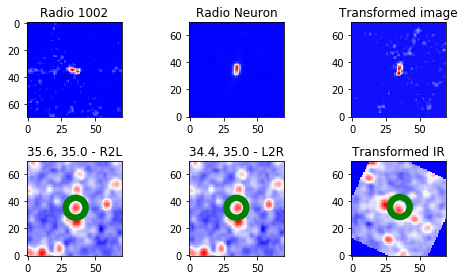

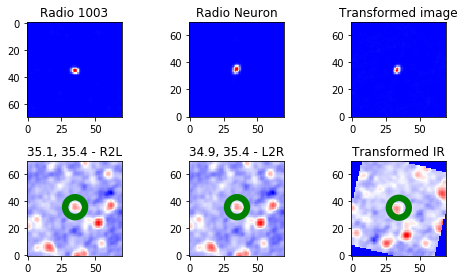

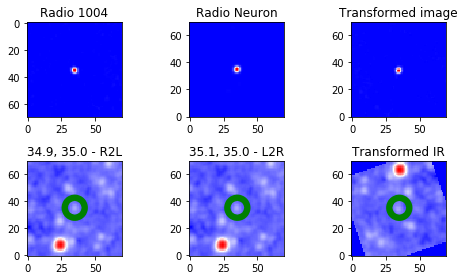

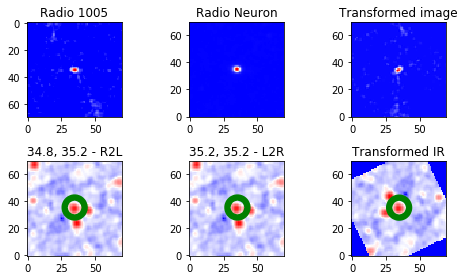

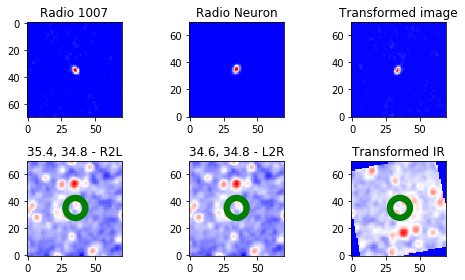

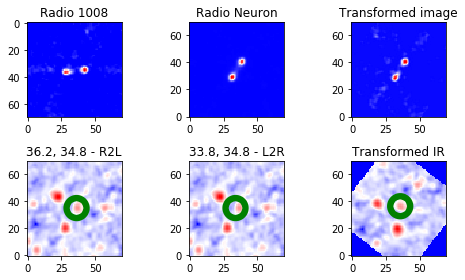

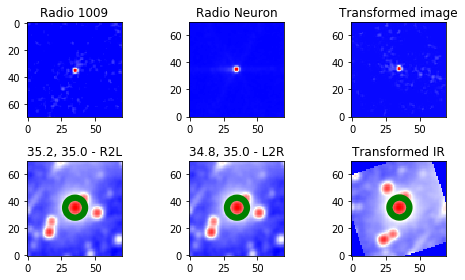

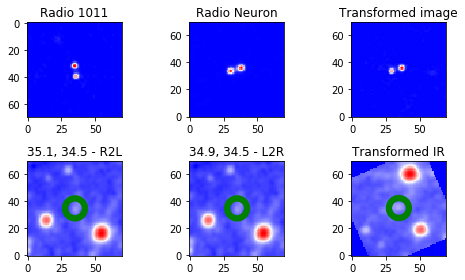

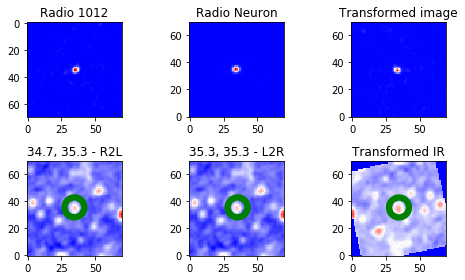

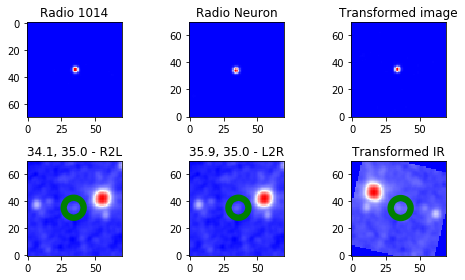

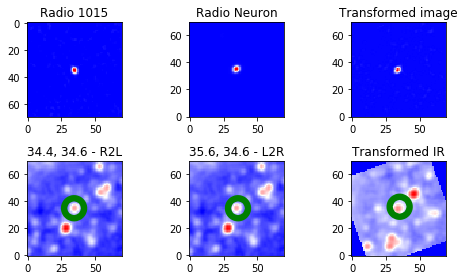

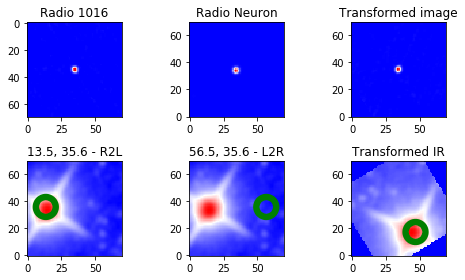

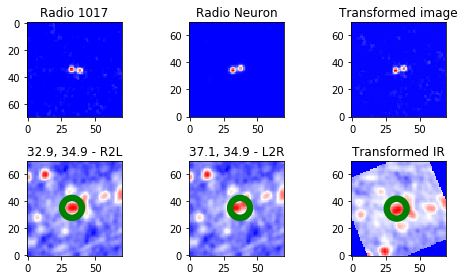

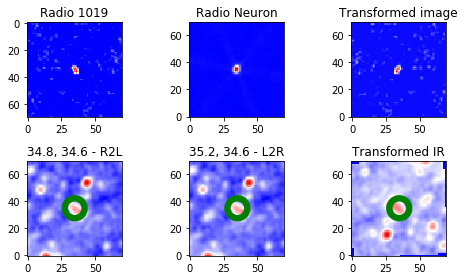

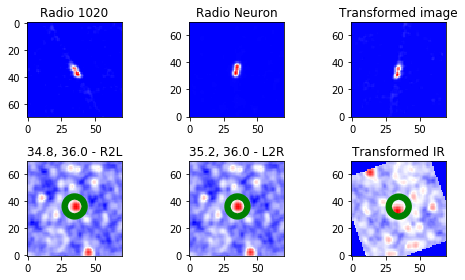

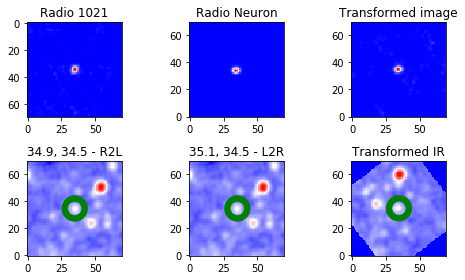

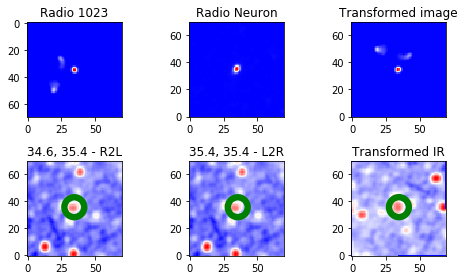

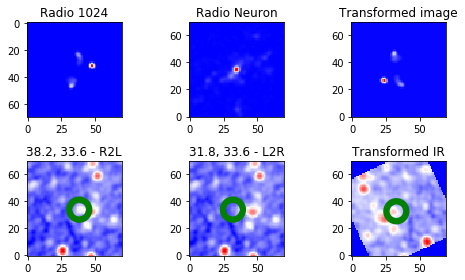

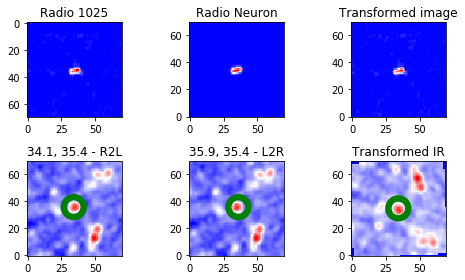

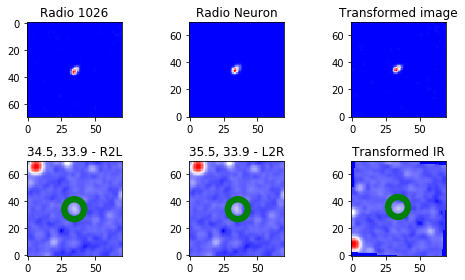

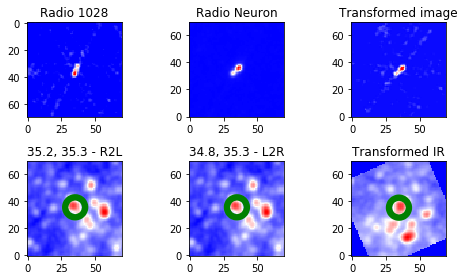

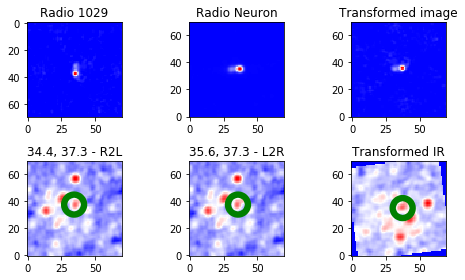

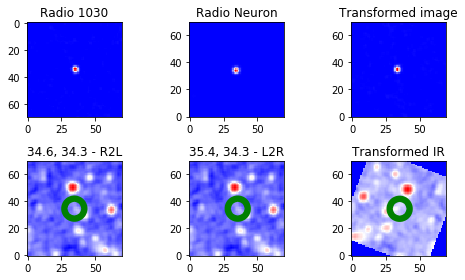

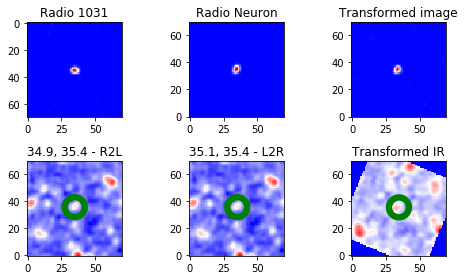

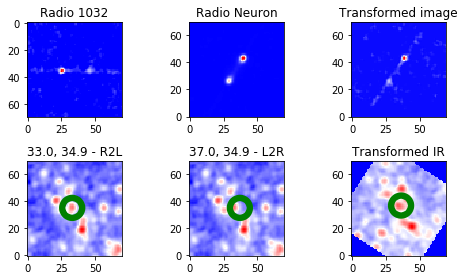

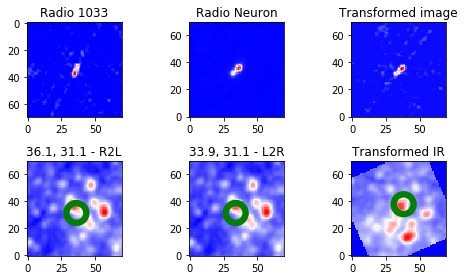

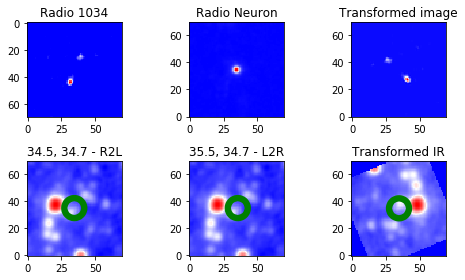

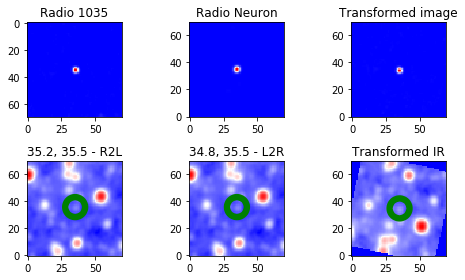

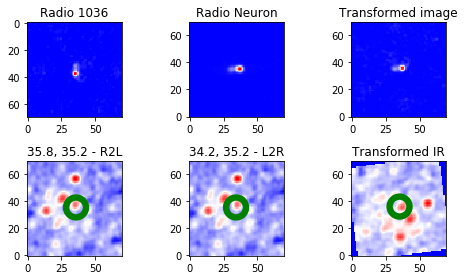

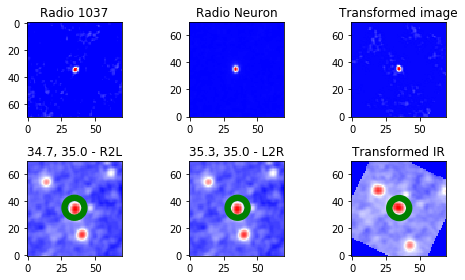

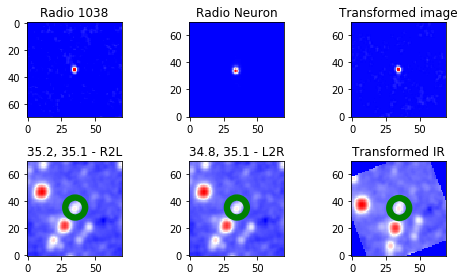

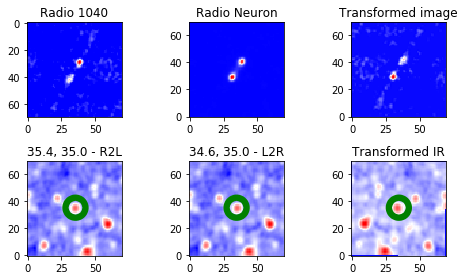

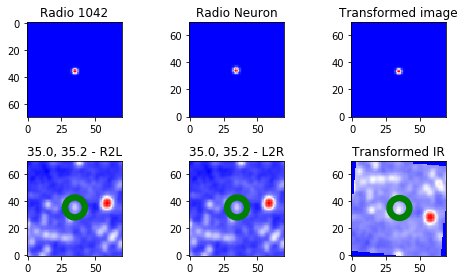

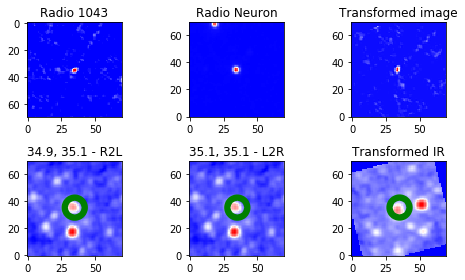

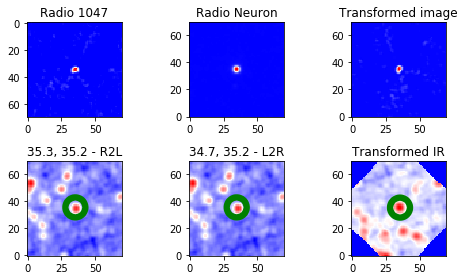

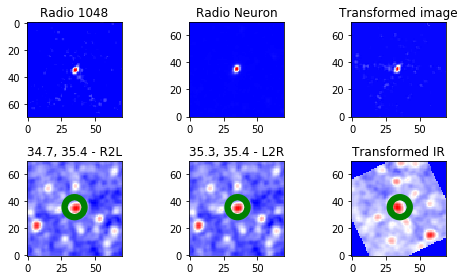

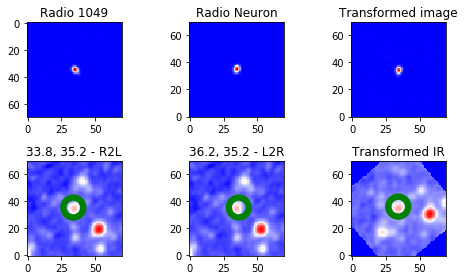

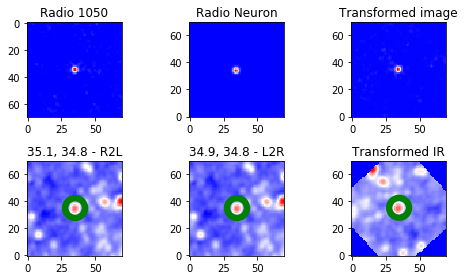

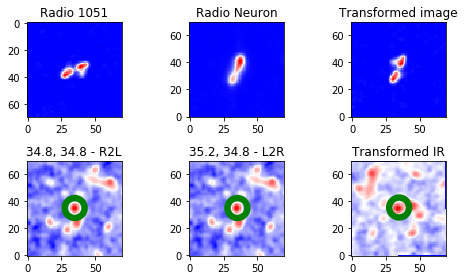

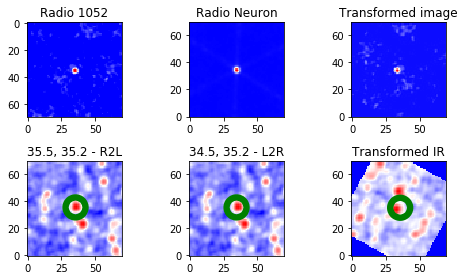

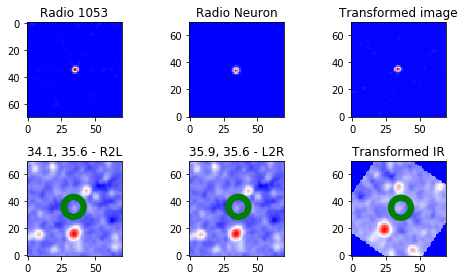

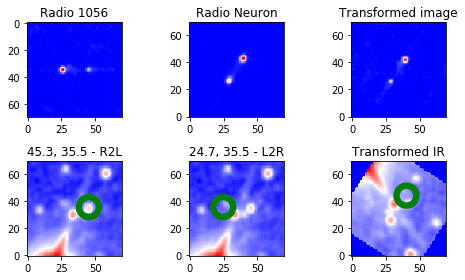

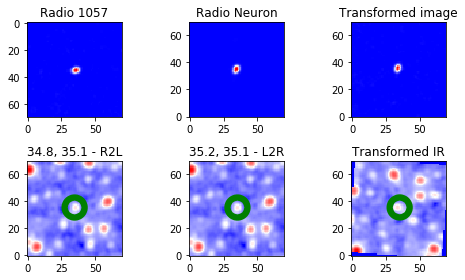

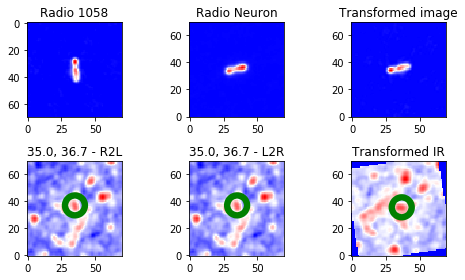

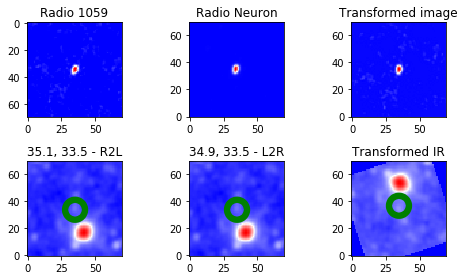

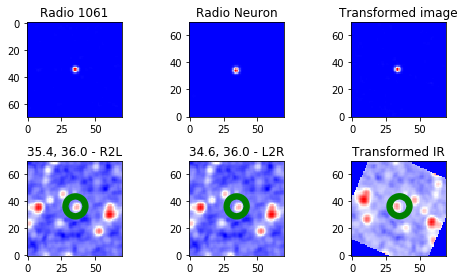

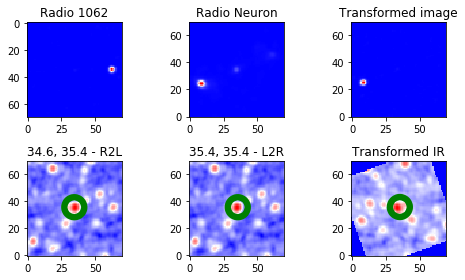

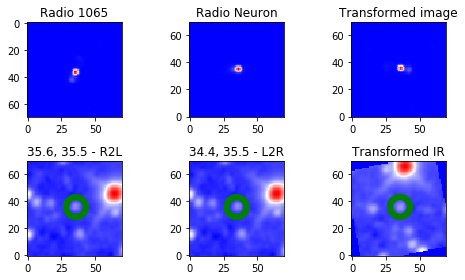

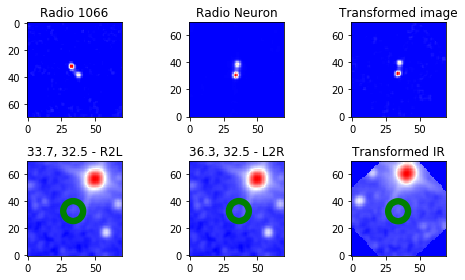

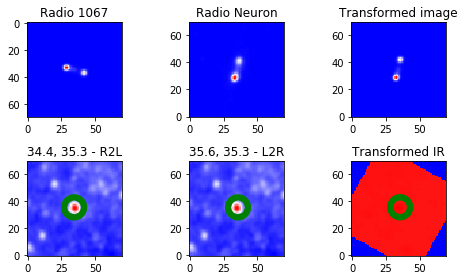

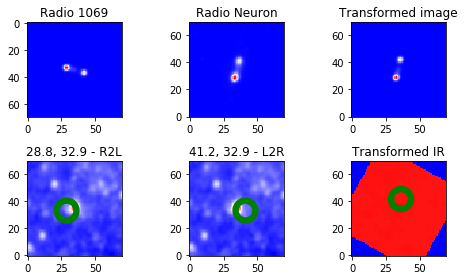

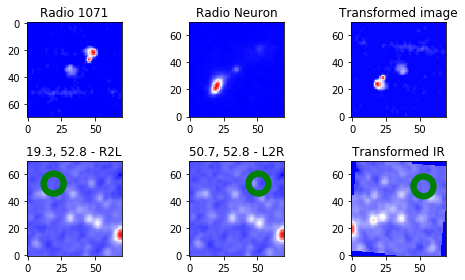

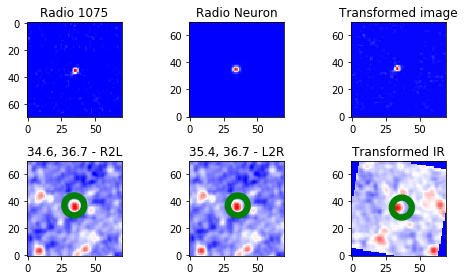

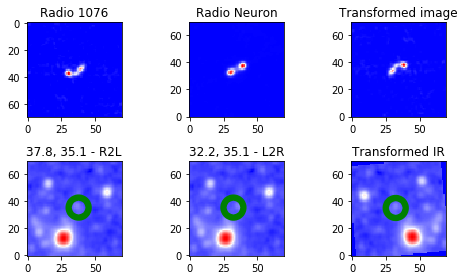

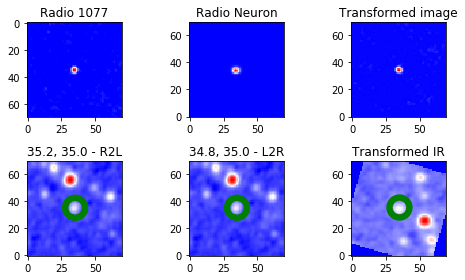

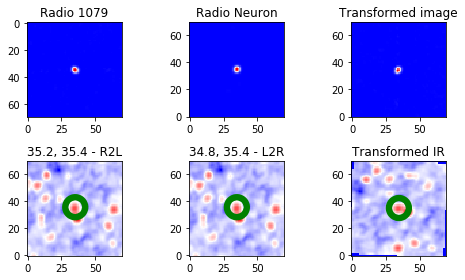

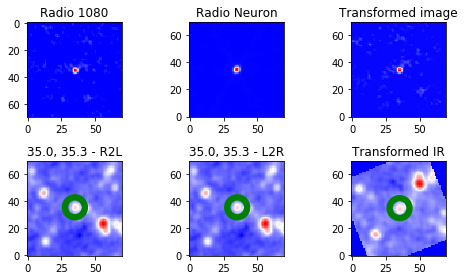

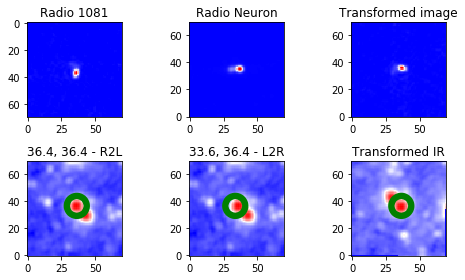

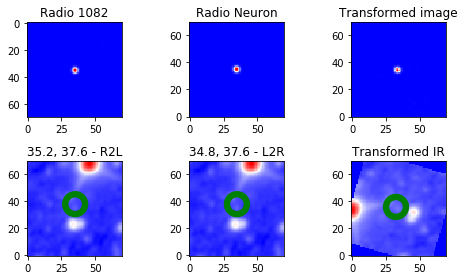

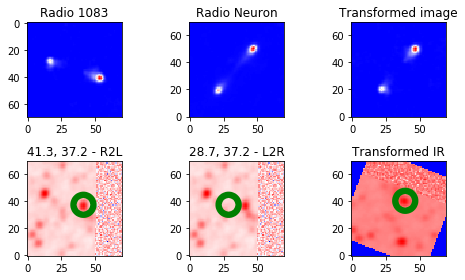

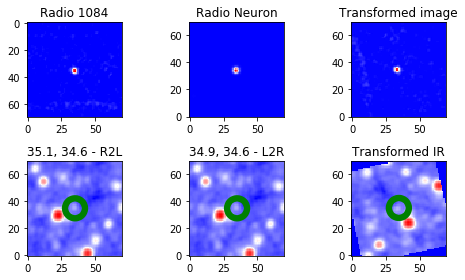

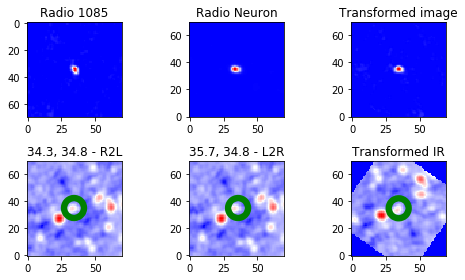

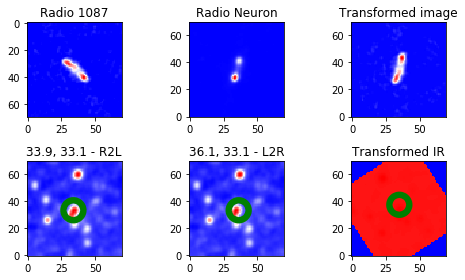

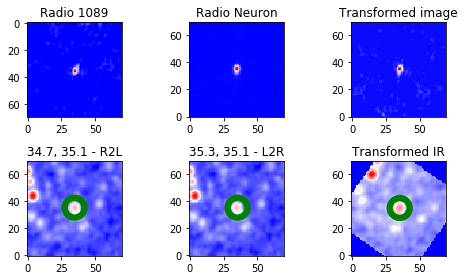

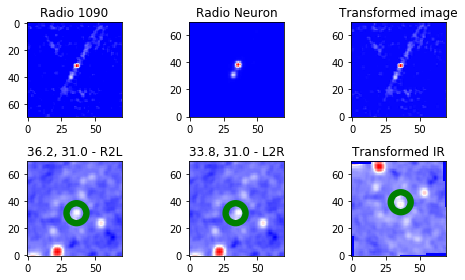

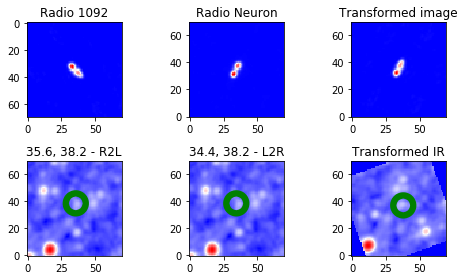

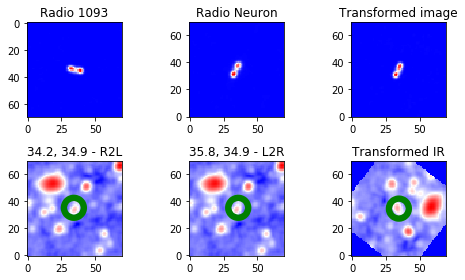

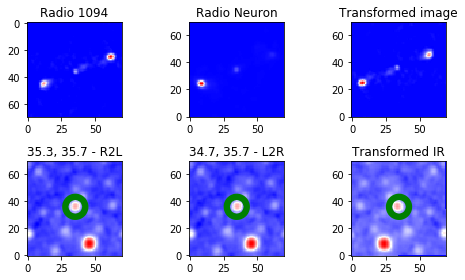

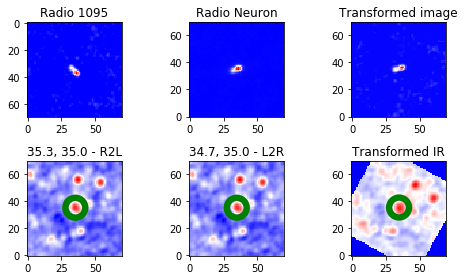

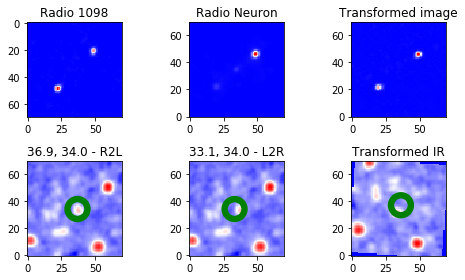

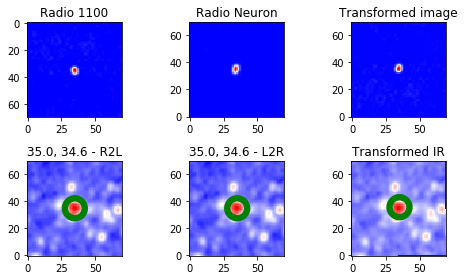

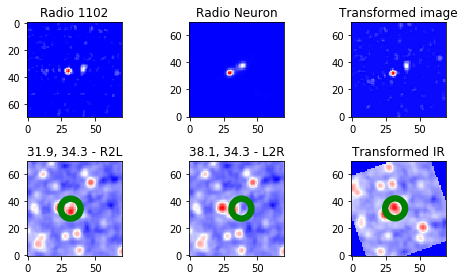

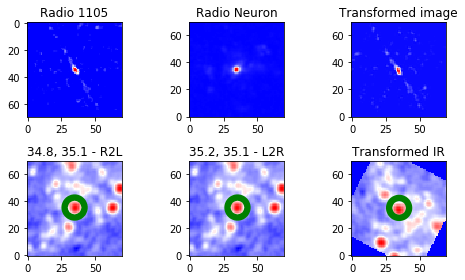

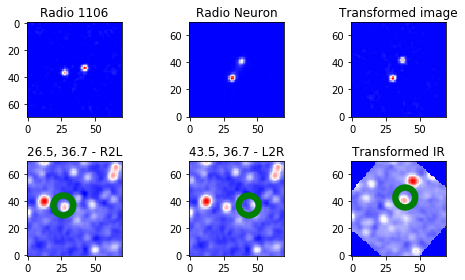

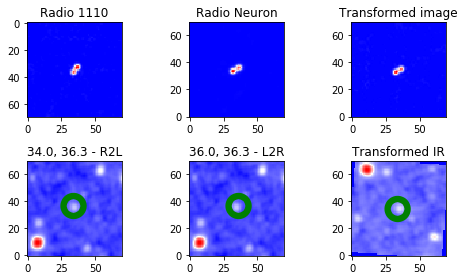

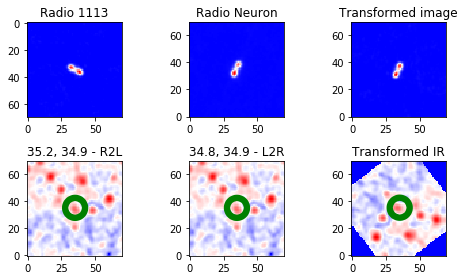

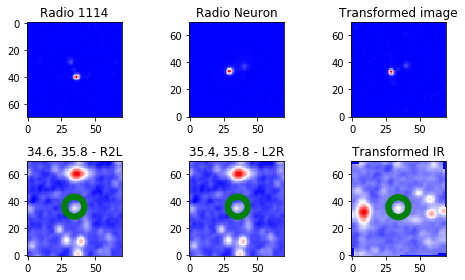

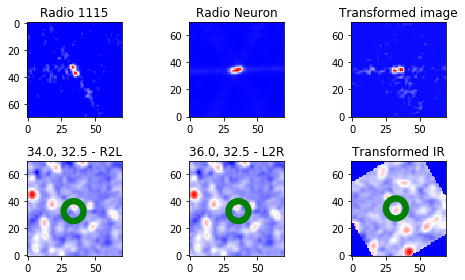

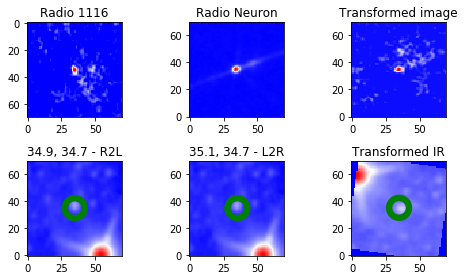

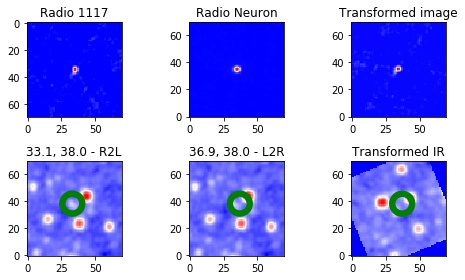

In [25]:
plt.close('all')
FIRST_PIX = 1.8*u.arcsecond # First pixel size

def apply_img_rotation(img, transform):
    img = img.T # Correct the C/Fortran mismatch of array formatting
    
    flip, angle = transform
    
    img = img_rotate(img, -np.rad2deg(angle), reshape=False)

    if flip == 1:
        img = img[:,::-1]
    
    return img
    
def return_transform(index, pos_min):
    rot = transform.transform(index=index).reshape(transform.header_info[1:])
    flip, ro = rot[pos_min[1], pos_min[0]][0]    

    return flip, ro

def return_bmu(index):
    hmap = ed.ed(index=index)
    pos_min = np.unravel_index(np.argmin(hmap), hmap.shape)

    return pos_min
    
def zoom(img, in_y, in_x):
    diff_x = in_x // 2
    diff_y = in_y // 2
    
    cen_x = img.shape[1] // 2
    cen_y = img.shape[0] // 2
    
    return img[cen_y-diff_y:cen_y+diff_y,
               cen_x-diff_x:cen_x+diff_x]
    
def pos_offset(row):
    r_pos  = SkyCoord(ra=row['radio.ra']*u.deg, dec=row['radio.dec']*u.deg, frame='icrs')
    ir_pos = SkyCoord(ra=row['consensus.ir_ra']*u.deg, dec=row['consensus.ir_dec']*u.deg, frame='icrs')
    
    return r_pos.spherical_offsets_to(ir_pos)

def rotate_offset(off_x, off_y, transform):
    flip, angle = transform
    
    off_y, off_x = off_x, off_y
    
    dx = off_x*np.cos(angle) - off_y*np.sin(angle)
    dy = off_x*np.sin(angle) + off_y*np.cos(angle)
    
    if flip == 1:
        dy = -dy
    
    return dx, dy
    
cmap = 'bwr'

for index in range(1000, 1120):
    
    row = df.iloc[index]
    
    if row['consensus.ir_ra'] == -99:
        continue

    # Load in images
    # ---------------------------------------------------------
    radio = images.get_image(index=index, channel=0)
    wise  = np.sqrt(images.get_image(index=index, channel=1))
    
    radio = zoom(radio, 70, 70)
    wise  = zoom(wise, 70, 70)
    # ---------------------------------------------------------

    # Get rotation information
    # ---------------------------------------------------------
    bmu_pos = return_bmu(index)
    rotation = return_transform(index, bmu_pos)
    # ---------------------------------------------------------
    
    # Obtain position offsets
    # ---------------------------------------------------------
    offset = pos_offset(row)
    # RA moves right to left
    off_ra  = -(offset[0].to(u.arcsecond) / FIRST_PIX) + radio.shape[0] // 2
    off_dec = offset[1].to(u.arcsecond) / FIRST_PIX + radio.shape[1] // 2
    # ---------------------------------------------------------
    
    # Get Neurons
    # ---------------------------------------------------------
    radio_neuron = zoom(som.get_neuron(x=bmu_pos[0], y=bmu_pos[1], channel=0), 70, 70)
    # ---------------------------------------------------------
    
    # Apply image transform
    # ---------------------------------------------------------
    radio_trans = apply_img_rotation(radio, rotation)
    ir_trans   = apply_img_rotation(wise, rotation)
    dx, dy = rotate_offset(-(offset[0].to(u.arcsecond) / FIRST_PIX),
                           offset[1].to(u.arcsecond) / FIRST_PIX,
                           rotation)
    dx = dx + radio.shape[0] // 2
    dy = dy + radio.shape[0] // 2
    # ---------------------------------------------------------
    
    
    fig, ((ax1, ax2, ax_rtrans), (ax3, ax4, ax_irtrans)) = plt.subplots(2,3, figsize=(7,4))
    
    ax1.imshow(radio, cmap=cmap)
    ax1.set(title=f'Radio {index}')
    
    ax2.imshow(radio_neuron, cmap=cmap, origin='lower left')
    ax2.set(title='Radio Neuron')
    
    ax_rtrans.imshow(radio_trans, cmap=cmap, origin='lower left')
    ax_rtrans.set(title='Transformed image')
    
    ax3.imshow(wise, cmap=cmap, origin='lower left')
    ax3.set(title=f'{off_ra:.1f}, {off_dec:.1f} - R2L')
    ax3.scatter(off_ra, off_dec, facecolors='none', edgecolors='green', s=40, linewidths=20)
    
    off_ra  = offset[0].to(u.arcsecond) / FIRST_PIX + radio.shape[0] // 2
    ax4.imshow(wise, cmap=cmap, origin='lower left')
    ax4.set(title=f'{off_ra:.1f}, {off_dec:.1f} - L2R')
    ax4.scatter(off_ra, off_dec, facecolors='none', edgecolors='green', s=40, linewidths=20)
    
    ax_irtrans.imshow(ir_trans, cmap=cmap, origin='lower left')
    ax_irtrans.set(title='Transformed IR')
    ax_irtrans.scatter(dx, dy, facecolors='none', edgecolors='green', s=40, linewidths=20)
    
    fig.tight_layout()
#     fig.show()
    fig.savefig(f"Images/Offset_Test/{index}.pdf")
    